In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import os

In [2]:
!nvidia-smi

Fri Nov 10 16:27:56 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:17:00.0 Off |                    0 |
| N/A   27C    P0              44W / 250W |  16220MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Load models

In [3]:
def downsample(input_channels, output_channels, kernel_size, apply_batchnorm=True, dropout_prob=0.0, weight_mean=0, weight_sd=0.02):
    layers = [nn.Conv2d(input_channels, output_channels, kernel_size, stride=2, padding=1, bias=False)]
    
    # Initialize the weights with mean and standard deviation
    nn.init.normal_(layers[0].weight, mean=weight_mean, std=weight_sd)
    
    if apply_batchnorm:
        layers.append(nn.BatchNorm2d(output_channels))
    layers.append(nn.LeakyReLU(0.2))
    
    if dropout_prob > 0.0:
        layers.append(nn.Dropout(dropout_prob))
    
    return nn.Sequential(*layers)

def upsample(input_channels, output_channels, kernel_size, apply_batchnorm=True, dropout_prob=0.0, weight_mean=0, weight_sd=0.02):
    layers = [nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=2, padding=1, bias=False)]
    
    # Initialize the weights with mean and standard deviation
    nn.init.normal_(layers[0].weight, mean=weight_mean, std=weight_sd)
    
    if apply_batchnorm:
        layers.append(nn.BatchNorm2d(output_channels))
    layers.append(nn.ReLU())
    
    if dropout_prob > 0.0:
        layers.append(nn.Dropout(dropout_prob))
    
    return nn.Sequential(*layers)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Define the downsample layers
        self.conv_layers = nn.ModuleList([
            downsample(1, 64, 4),
            downsample(64, 128, 4),
            downsample(128, 256, 4),
            downsample(256, 512, 4),
            downsample(512, 512, 4),
            downsample(512, 512, 4),
            downsample(512, 512, 4),
            downsample(512, 512, 4)
        ])

        # Define the upsample layers
        self.up_layers = nn.ModuleList([
            upsample(512, 512, 4),
            upsample(1024, 512, 4),
            upsample(1024, 512, 4),
            upsample(1024, 512, 4),
            upsample(1024, 256, 4),
            upsample(512, 128, 4),
            upsample(256, 64, 4)
        ])

        # Final convolutional layer for generating the output
        self.last = nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1)

    def forward(self, x):
        # Downsampling through the model
        skips = []
        for layer in self.conv_layers:
            x = layer(x)
            skips.append(x)
        
        skips = skips[:-1]

        # Upsampling and establishing skip connections
        for layer, skip in zip(self.up_layers, reversed(skips)):
            x = layer(x)
            x = torch.cat([x, skip], dim=1)

        x = self.last(x)
        return x

# Instantiate the Generator model
unet = Generator()
generator = Generator()

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Discriminator, self).__init__()
        
        # The first few convolutional layers using the downsample block
        self.downsample1 = downsample(input_channels * 2, 64,4, apply_batchnorm=False)
        self.downsample2 = downsample(64, 128,4)
        self.downsample3 = downsample(128, 256,4)
        
        # Continue with the remaining convolutional layers
        self.conv4 = nn.Conv2d(256, 512, 4, stride=1, padding=0)  # No padding here
        self.conv5 = nn.Conv2d(512, 1, 4, stride=1, padding=0)
        
        # Batch normalization layer
        self.batchnorm1 = nn.BatchNorm2d(512)
        
        # Activation function
        self.leaky_relu = nn.LeakyReLU(0.2)
        
    def forward(self, input_image, target_image):
        # Concatenate input and target images along the channel dimension
        x = torch.cat((input_image, target_image), dim=1)
        x = self.downsample1(x)
        x = self.downsample2(x)
        x = self.downsample3(x)
        x = nn.ZeroPad2d((1, 1, 1, 1))(x)
        
        # Continue with the remaining convolutional layers
        x = self.conv4(x)
        x = self.batchnorm1(x)
        x = self.leaky_relu(x)
        x = nn.ZeroPad2d((1, 1, 1, 1))(x)
        x = self.conv5(x)
        
        return x

# Define the number of input and output channels (adjust according to your needs)
input_channels = 1  # Adjust this based on your actual input channels
output_channels = 1  # Adjust this based on your actual output channels

# Instantiate the Discriminator model
discriminator = Discriminator(input_channels, output_channels)

In [5]:
# Load unet
unet.load_state_dict(torch.load('pytorch_generator_only.pth'))
unet.eval()

# Load pix2pix
discriminator.load_state_dict(torch.load('pytorch_pix2pix_discriminator.pth'))
discriminator.eval()
generator.load_state_dict(torch.load('pytorch_pix2pix_generator.pth'))
generator.eval()

Generator(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2

# Load data

In [6]:
input_data = np.load('/scratch/amath12/new_input_data_pickled.pkl', allow_pickle=True)
output_data= np.load('/scratch/amath12/new_output_data_pickled.pkl', allow_pickle=True)

print(input_data.shape, output_data.shape)

(1360, 256, 256) (1360, 256, 256)


In [7]:
# unsqueeze the data
input_data = np.expand_dims(input_data, axis=1)
output_data = np.expand_dims(output_data, axis=1)   

print(input_data.shape, output_data.shape)

(1360, 1, 256, 256) (1360, 1, 256, 256)


In [8]:
# make dataloader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

# convert to tensor
# X_train = torch.from_numpy(X_train).float()
# y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# create dataloader
# train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batch_size = 300
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

# compare prediction visually, UNet vs pix2pix generator

In [9]:
def generate_images(test_input, tar, prediction1, prediction2):
  plt.figure(figsize=(15, 15))
  display_list = [test_input, tar, prediction1, prediction2]
  title = ['Input Image', 'Ground Truth', 'UNet Predicted Image', 'Pix2Pix Predicted Image']
  for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5, cmap='jet')
    plt.axis('off')
  plt.show()

# def generate_images_samescale(test_input, tar, prediction):
#   '''
#   ensures the target and predicted are on the same color scale
#   '''

#   plt.figure(figsize=(15, 15))

#   display_list = [test_input[0], tar[0], prediction[0]]
#   title = ['Input Image', 'Ground Truth', 'Predicted Image']

#   global_min = min([np.min(img) for img in [tar[0], prediction[0]]])
#   global_max = max([np.max(img) for img in [tar[0], prediction[0]]])

#   plt.subplot(1, 3, 1)
#   plt.title(title[0])
#   plt.imshow(test_input, cmap='jet')
#   plt.axis('off')
#   plt.subplot(1, 3, 2)
#   plt.title(title[1])
#   plt.imshow(tar, cmap='jet', vmin=global_min, vmax=global_max)
#   plt.axis('off')
#   plt.subplot(1, 3, 3)
#   plt.title(title[2])
#   plt.imshow(prediction, cmap='jet', vmin=global_min, vmax=global_max)
#   plt.axis('off')  
#   # for i in range(3):
#   #   plt.subplot(1, 3, i+1)
#   #   plt.title(title[i])
#   #   # Getting the pixel values in the [0, 1] range to plot.
#   #   #plt.imshow(display_list[i] * 0.5 + 0.5, cmap='jet')
#   #   plt.imshow(display_list[i], cmap='jet', vmin=global_min, vmax=global_max)
#   #   #plt.colorbar()
#   #   plt.axis('off')
#   plt.show()

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
unet.to(device)
generator.to(device)

Generator(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2

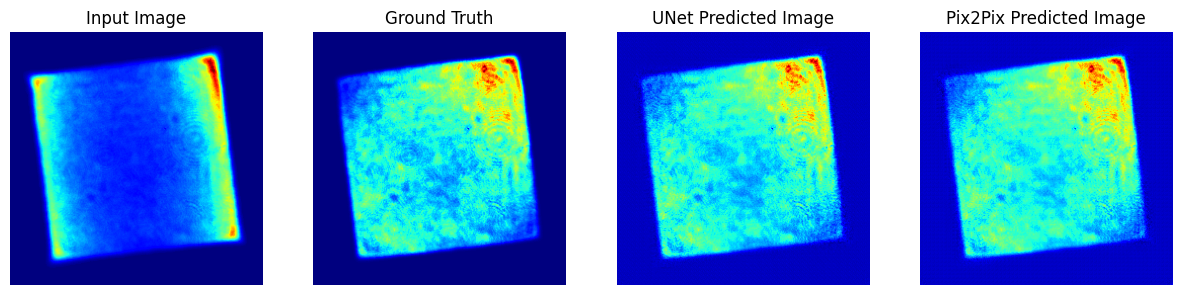

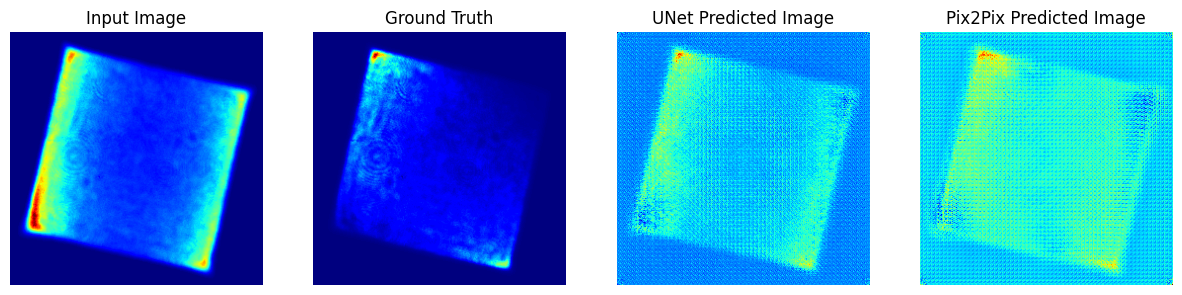

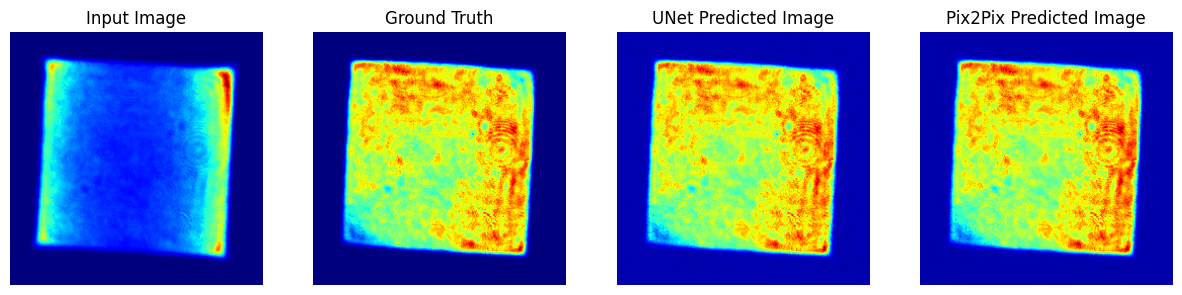

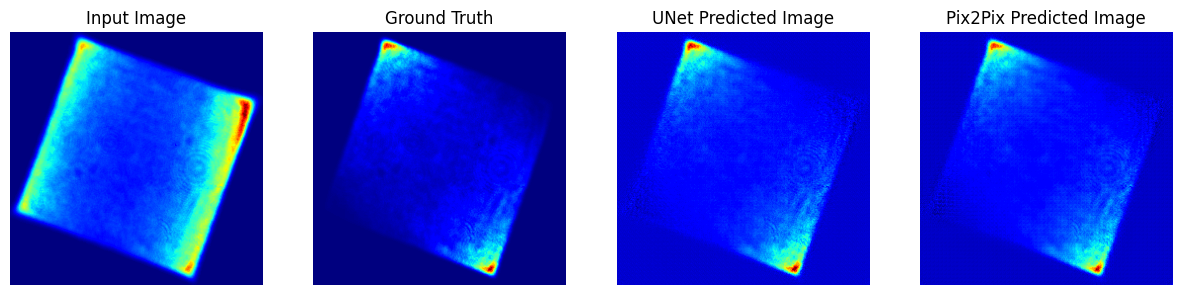

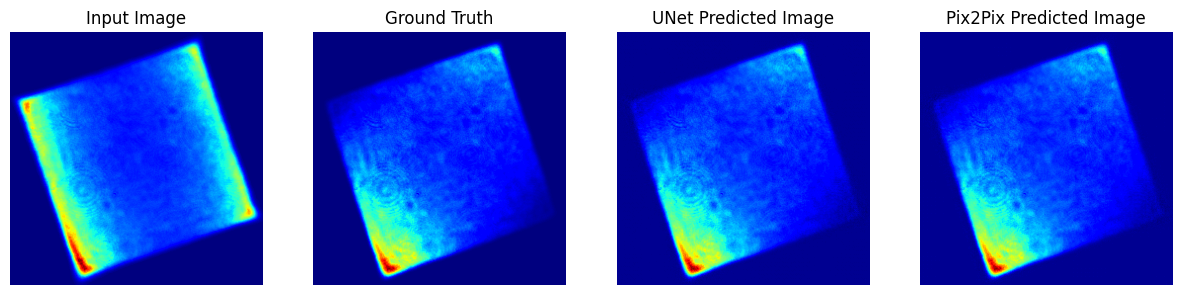

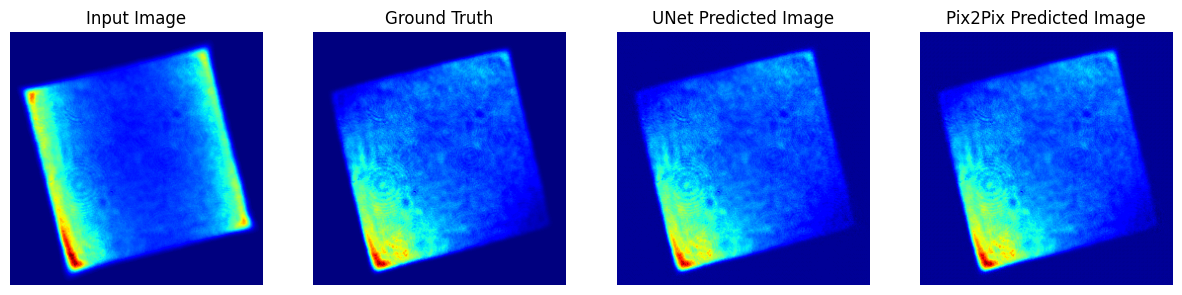

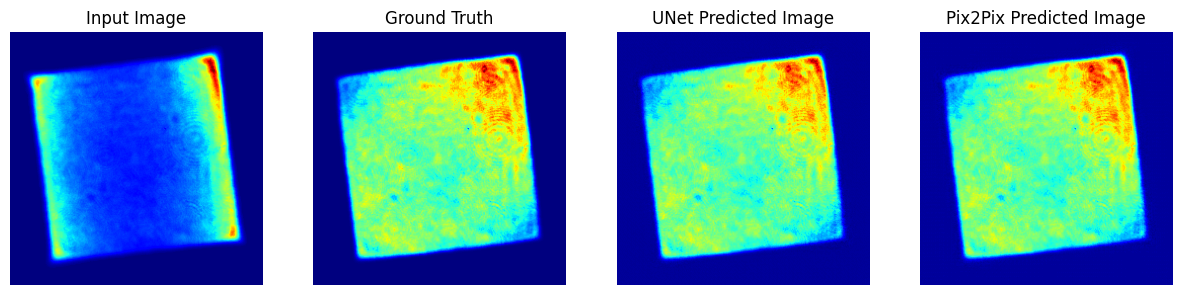

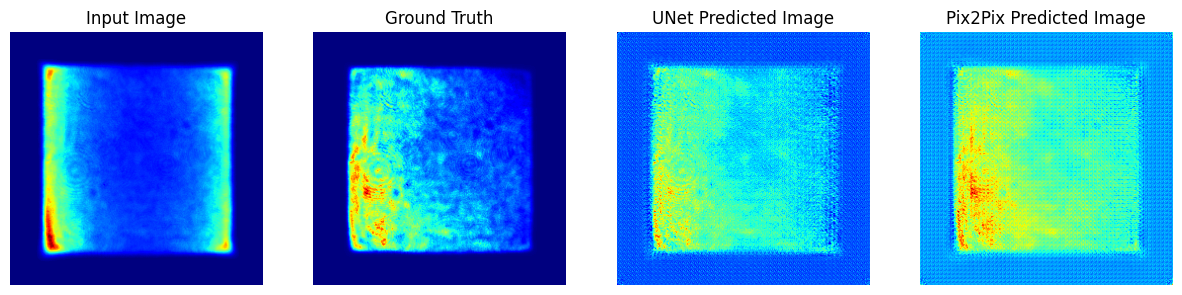

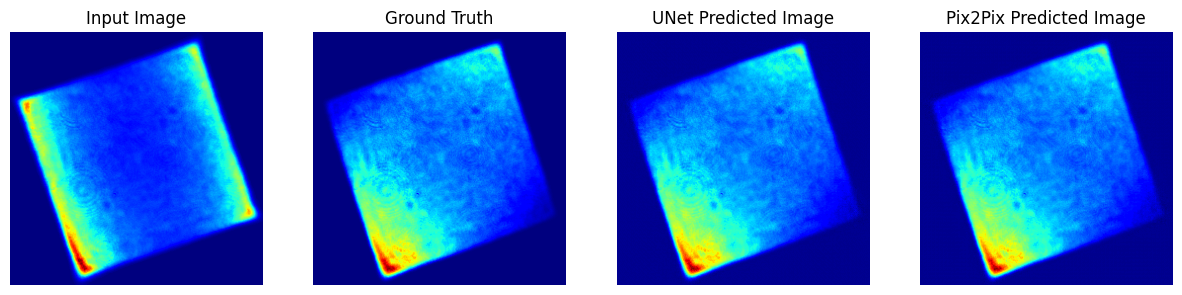

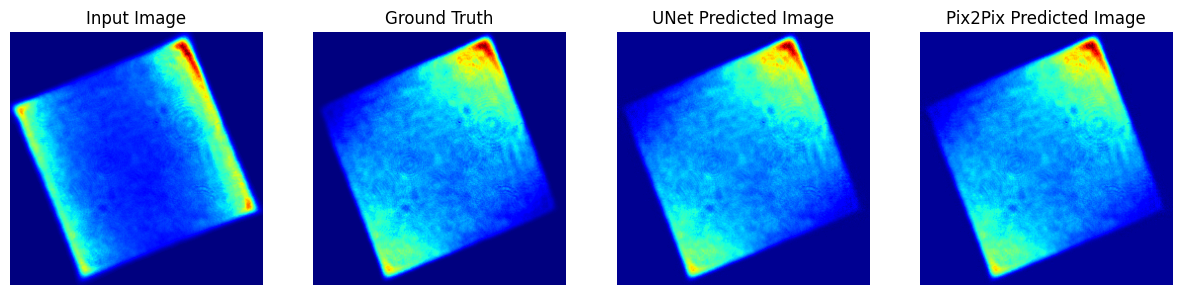

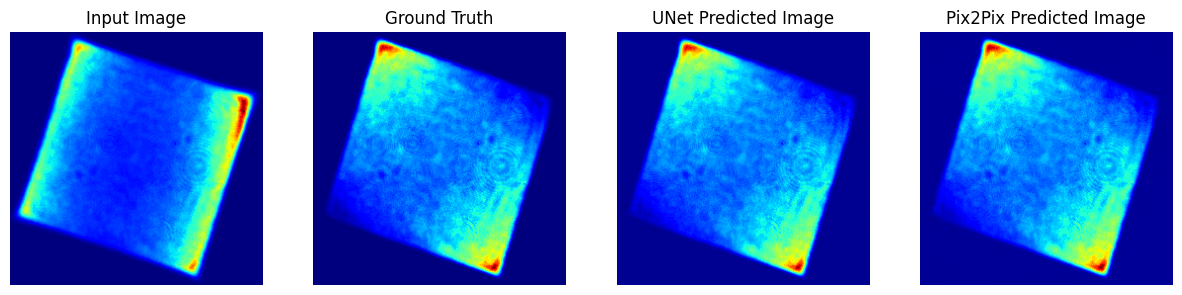

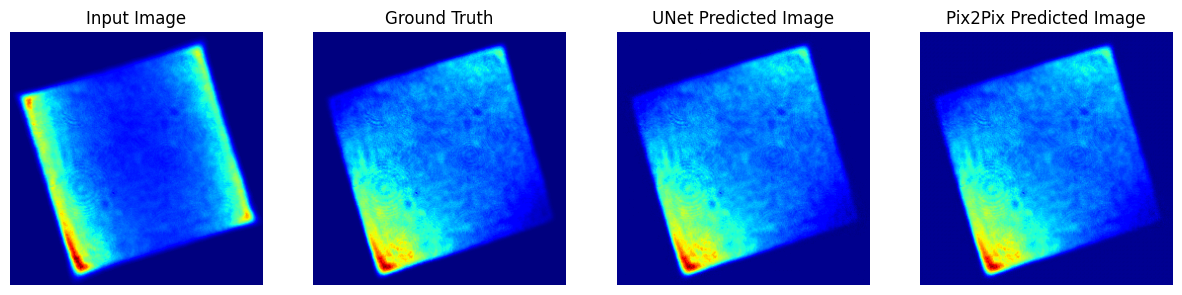

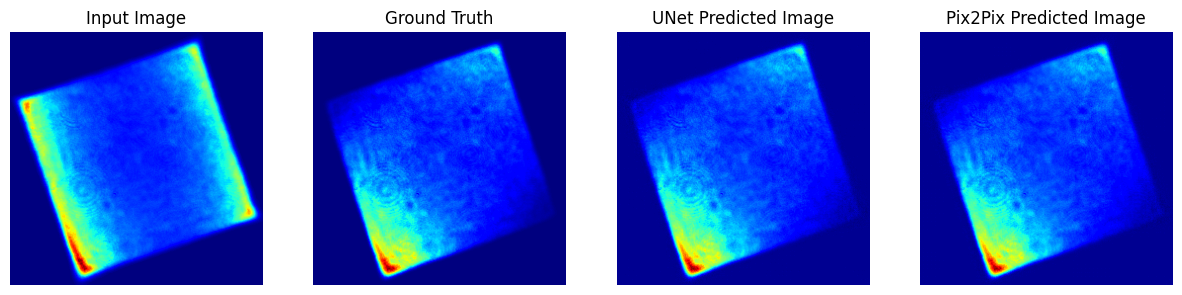

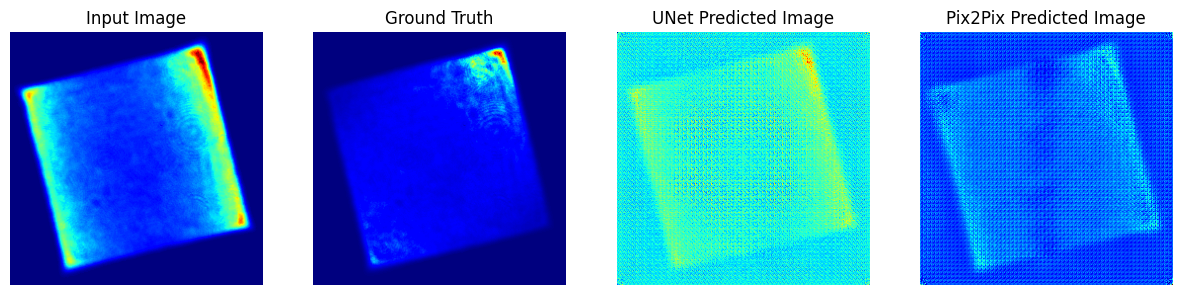

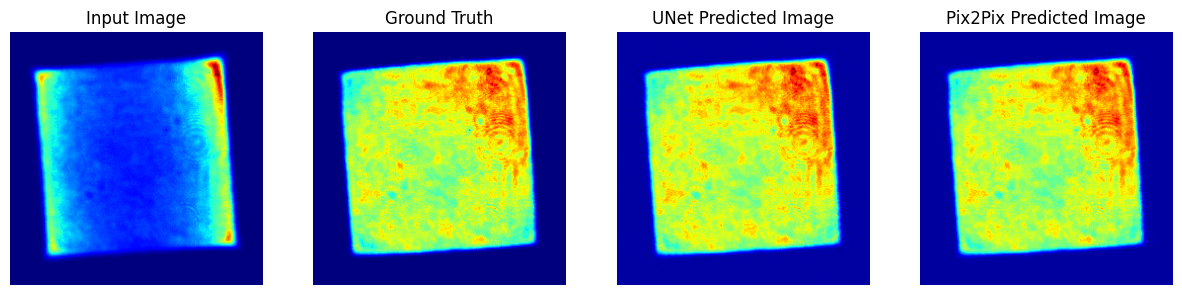

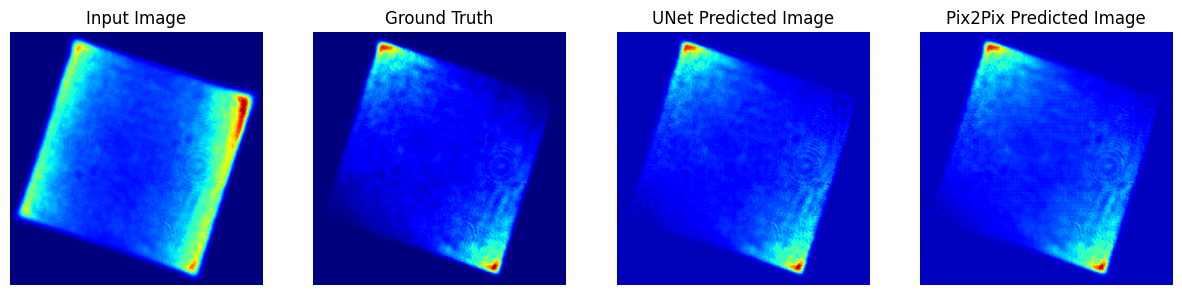

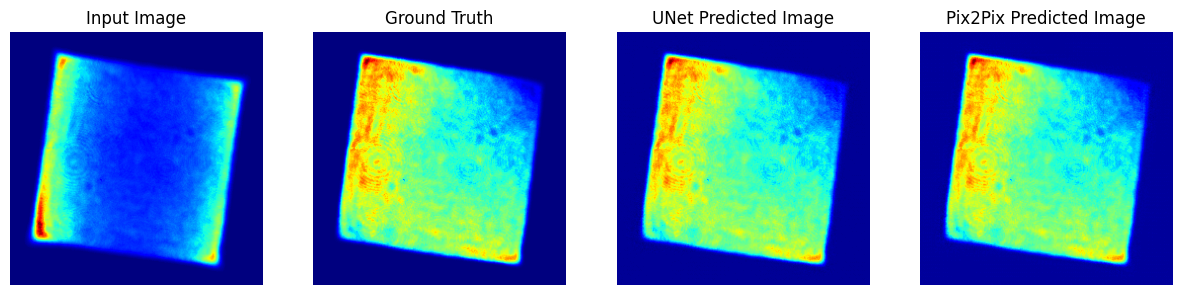

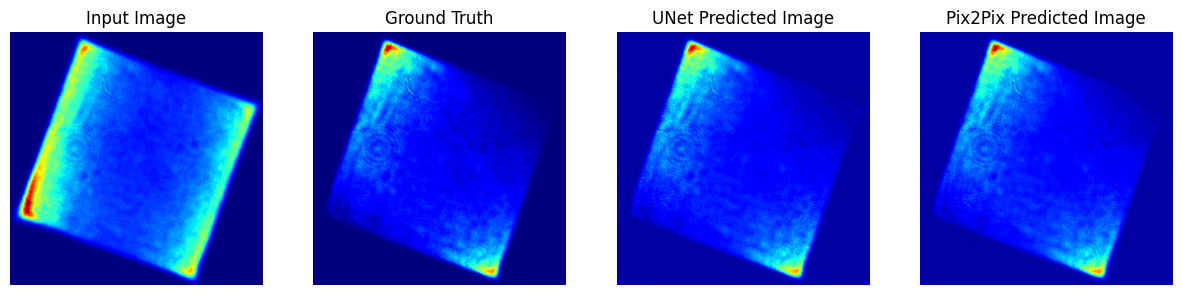

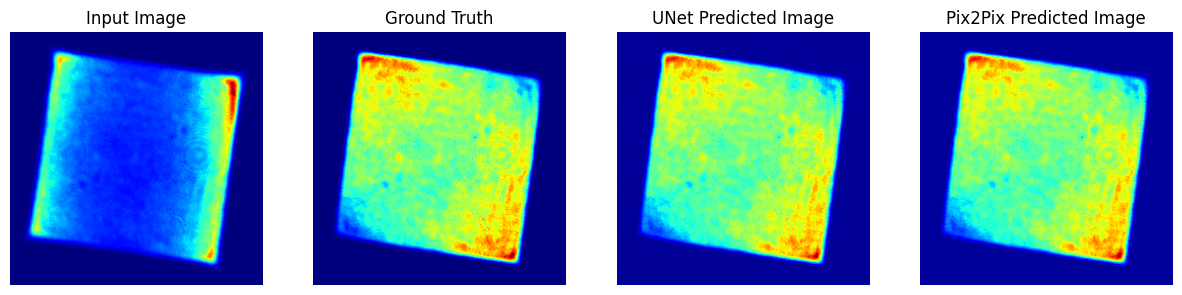

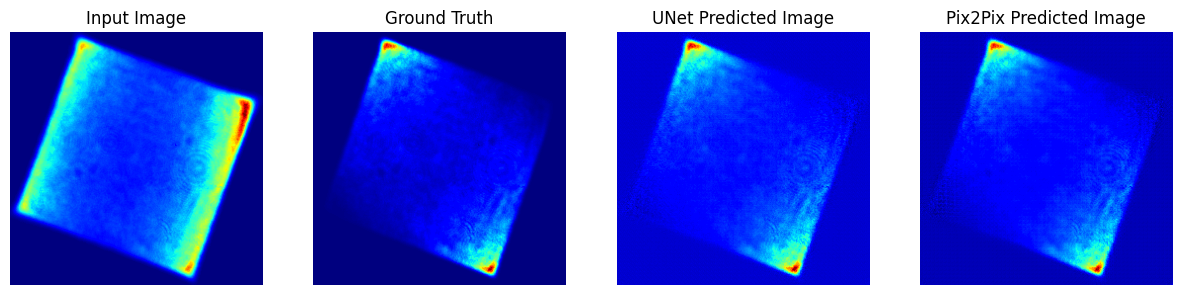

In [12]:
for image_index in range(0, 200, 10):
    test_input = X_test[image_index].unsqueeze(0).to(device)  # Add batch dimension
    tar = y_test[image_index].unsqueeze(0).to(device)
    with torch.no_grad():
        unet_prediction = unet(test_input).cpu().squeeze()  # Generate prediction and move to CPU
        generator_prediction = generator(test_input).cpu().squeeze()  # Generate prediction and move to CPU
    test_input = X_test[image_index].cpu().squeeze(0)  # Move input to CPU
    tar = y_test[image_index].cpu().squeeze(0)  # Move target to CPU

    generate_images(test_input, tar, unet_prediction, generator_prediction)

# compare MSEs UNet vs pix2pix generator

In [13]:
from sklearn.metrics import mean_squared_error
from torch.nn.functional import mse_loss
from scipy.stats import ttest_ind
from tqdm import tqdm

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
unet.to(device)
generator.to(device)

Generator(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2

In [16]:
# Number of bootstrap samples
n_bootstrap = 100
batch_size = 64  # Set the batch size for the DataLoader

# Lists to store MSEs for both models
mse_list_unet = []
mse_list_generator = []

for _ in tqdm(range(n_bootstrap)):
    # Bootstrap sampling
    indices = np.random.choice(len(X_test), len(X_test), replace=True)
    X_bootstrap = X_test[indices]
    y_bootstrap = y_test[indices]

    # Create a DataLoader for the bootstrapped data
    bootstrap_dataset = TensorDataset(X_bootstrap, y_bootstrap)
    bootstrap_loader = DataLoader(bootstrap_dataset, batch_size=batch_size, shuffle=False)

    # Variables to accumulate batch MSEs
    mse_accum_unet = 0.0
    mse_accum_generator = 0.0

    for X_batch, y_batch in bootstrap_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Inference and MSE calculation for unet
        with torch.no_grad():
            pred_batch_unet = unet(X_batch)
            mse_accum_unet += mse_loss(pred_batch_unet, y_batch).item() * X_batch.size(0)

        # Inference and MSE calculation for generator
        with torch.no_grad():
            pred_batch_generator = generator(X_batch)
            mse_accum_generator += mse_loss(pred_batch_generator, y_batch).item() * X_batch.size(0)

    # Average MSE over all batches for this bootstrap sample
    mse_list_unet.append(mse_accum_unet / len(X_bootstrap))
    mse_list_generator.append(mse_accum_generator / len(X_bootstrap))

# Perform t-test on the accumulated MSEs
t_stat, p_val = ttest_ind(mse_list_unet, mse_list_generator)

# Decide whether the difference is statistically significant
alpha = 0.05  # Or another significance level you choose
if p_val < alpha:
    print("The difference in MSEs is statistically significant.")
else:
    print("The difference in MSEs is not statistically significant.")

100%|████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.95it/s]

The difference in MSEs is statistically significant.


In [17]:
print(f"Mean MSE for unet: {np.mean(mse_list_unet):.4f}")
print(f"Mean MSE for generator: {np.mean(mse_list_generator):.4f}")
print(f"The p-value is {p_val}")

Mean MSE for unet: 0.0004
Mean MSE for generator: 0.0004
The p-value is 2.0274777662418392e-14


# compare prediction time UNet vs pix2pix Generator

In [18]:
import time

In [19]:
# Lists to store inference times
times_unet = []
times_generator = []

# Iterate through the test data one datapoint at a time
for i in tqdm(range(len(X_test))):
    # Get the i-th test datapoint and add a batch dimension of 1
    x_single = X_test[i].unsqueeze(0).to(device)

    # Time inference for unet
    start_time = time.time()
    with torch.no_grad():
        _ = unet(x_single)
    end_time = time.time()
    times_unet.append(end_time - start_time)

    # Time inference for generator
    start_time = time.time()
    with torch.no_grad():
        _ = generator(x_single)
    end_time = time.time()
    times_generator.append(end_time - start_time)

# Convert lists to arrays for statistical testing
times_unet_array = np.array(times_unet)
times_generator_array = np.array(times_generator)

# Perform t-test on inference times
t_stat, p_val = ttest_ind(times_unet_array, times_generator_array)

print(f'T-statistic: {t_stat}, P-value: {p_val}')

# Decide whether the difference is statistically significant
alpha = 0.05  # Or another significance level you choose
if p_val < alpha:
    print("The difference in inference times is statistically significant.")
else:
    print("The difference in inference times is not statistically significant.")

100%|███████████████████████████████████████████████████████████████| 272/272 [00:00<00:00, 307.97it/s]

T-statistic: 19.0260534913282, P-value: 3.3547287968207325e-62
The difference in inference times is statistically significant.
